# [Computational Social Science] Project 4: Unsupervised Learning

## Data Description and Preprocessing

We explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [61]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

# importing dependencies
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_last')
#K.set_image_dim_ordering('th')
from keras.datasets import mnist
import keras

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

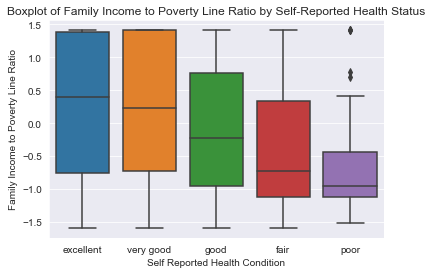

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

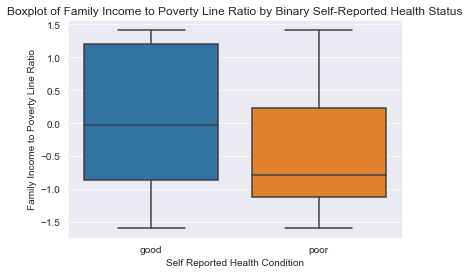

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

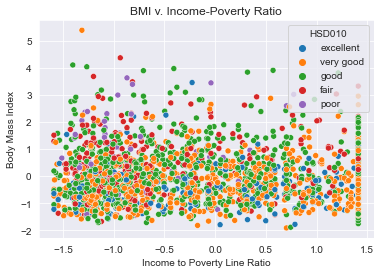

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

####  Does the binary variable provide a helpful simplification of the categorial variable?
The plots below show that the binary variable performs as expected, showing that when tested individually, BMI, age, the level of education and total household income are associated with different health outcomes, even when grouping health outcomes to a binary variable. 

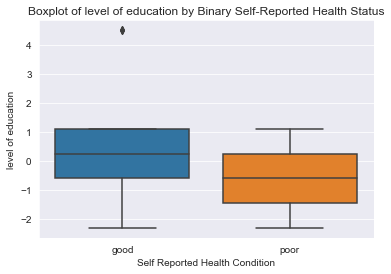

In [20]:
# Boxplot of hsd010_binary and level of education
ax = sns.boxplot(x = 'HSD010_binary', y = 'DMDHREDU', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "level of education")
ax.set_title("Boxplot of level of education by Binary Self-Reported Health Status")
plt.show()

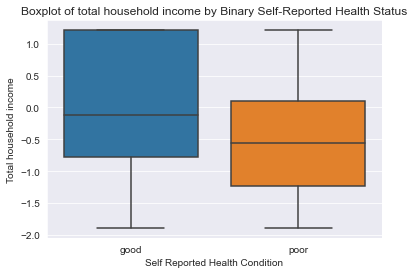

In [44]:
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDHHIN2', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Total household income")
ax.set_title("Boxplot of total household income by Binary Self-Reported Health Status")
plt.show()

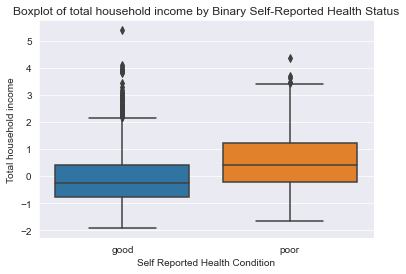

In [45]:
ax = sns.boxplot(x = 'HSD010_binary', y = 'BMXBMI', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "BMI")
ax.set_title("Boxplot of BMI by Binary Self-Reported Health Status")
plt.show()

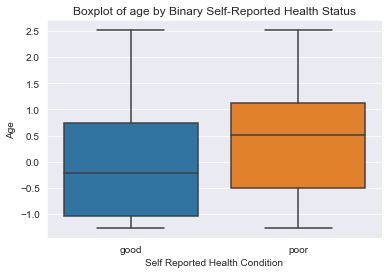

In [59]:
ax = sns.boxplot(x = 'HSD010_binary', y = 'RIDAGEYR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Age")
ax.set_title("Boxplot of age by Binary Self-Reported Health Status")
plt.show()


Before we move to working on unsupervised methods, we'll drop our target variables again:

In [21]:
#create X by dropping target variables
X =nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1,inplace=False)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explains by each component.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [22]:
#fitting the PCA object on X with 10 principal components, also storing the rotated X as pc_X
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pc_X = pca.fit_transform(X)

### Barplot of Components

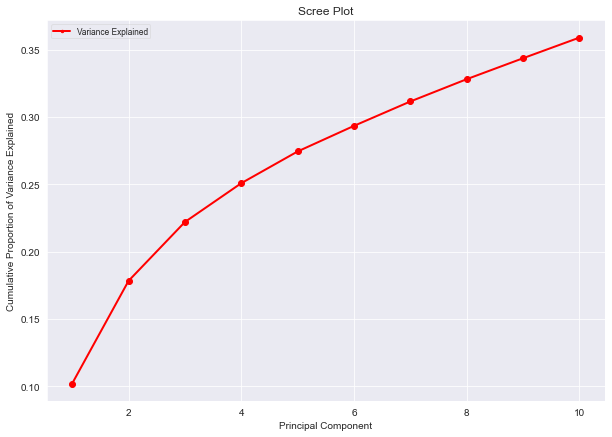

In [8]:
# from https://stats.stackexchange.com/questions/12819/how-to-draw-a-scree-plot-in-python

# creating a scree plot to examine how useful each principal component is for explaining variance in X

from matplotlib import font_manager

sing_vals = np.arange(1, pca.n_components + 1)
fig = plt.figure(figsize=(10,7))
plt.plot(sing_vals, np.cumsum(pca.explained_variance_ratio_), 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Proportion of Variance Explained')
leg = plt.legend(['Variance Explained'], loc='best', borderpad=0.3, 
                 shadow=False, prop=font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
plt.show()

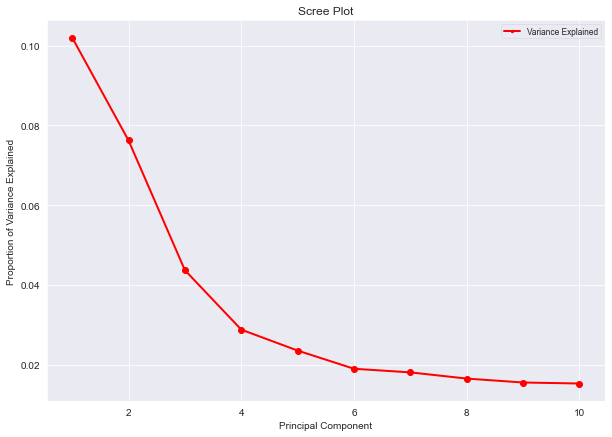

In [9]:
sing_vals = np.arange(1, pca.n_components + 1)
fig = plt.figure(figsize=(10,7))
plt.plot(sing_vals, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Variance Explained'], loc='best', borderpad=0.3, 
                 shadow=False, prop=font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
plt.show()

### How many components will you use to fit a supervised learning model?

Four components seems to be enough. From the proportion of variance explained, there looks like an "elbow" in the scree plot after the third component (ISLR, 384). The 5th component explains about the same proportion of variance as the 4th component, and so it seems like it would not be that useful after the fourth component. 

It is a little concerning, however, that the cumulative proportion of variance explained in 4 components is only around 25%. 

In [10]:
# double checking the visual elbow analysis with KneeLocator

from kneed import KneeLocator

kl = KneeLocator(range(0,10), pca.explained_variance_ratio_, curve='convex', direction='decreasing')
kl.elbow

3

KneeLocator also found the elbow at 3.

### 2D Scatterplot of the first two components

In [13]:
# dataframe of the rotated X 
pca_df = pd.DataFrame(data = pc_X, 
                      columns = [('principal component ' + str(i)) for i in range(1,pca.n_components+1)])
pca_df.head(3)

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,9.527811,-0.816224,-1.867099,-2.109863,-3.929246,-0.181063,-3.846346,-2.937880,1.519137,0.701853
1,-5.838339,-3.692573,3.805735,-1.029529,0.394955,1.600431,2.708244,-0.731396,0.407781,-2.411322
2,-0.719454,-2.573200,0.907881,-4.755813,-1.798564,0.873350,-1.027385,0.632016,0.548426,0.497264


<Figure size 432x288 with 0 Axes>

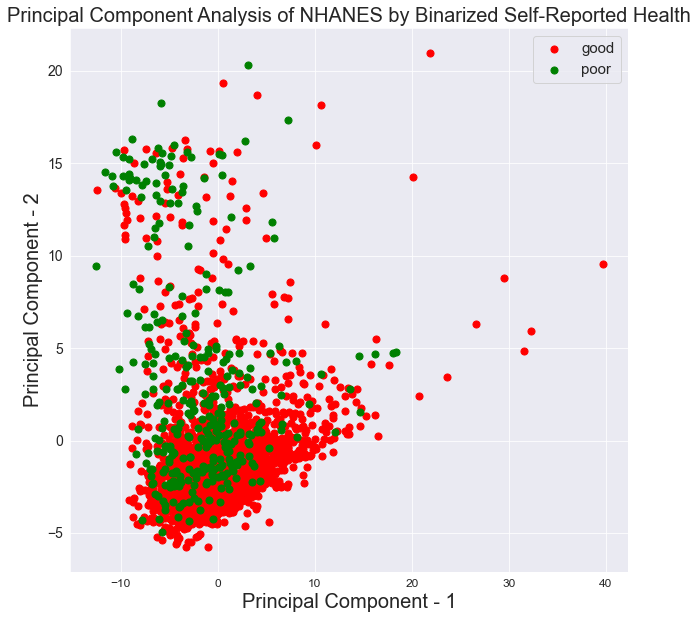

In [14]:
# plotting X with the binarized target variable

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES by Binarized Self-Reported Health",fontsize=20)
targets = ['good', 'poor']
colors = ['r', 'g']

for target, color in zip(targets,colors):
    indicesToKeep = nhanes_scaled['HSD010_binary'] == target
    plt.scatter(pca_df.loc[indicesToKeep.reset_index(drop = True), 'principal component 1']
               , pca_df.loc[indicesToKeep.reset_index(drop = True), 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

## K-means

Choose a clustering algorithm and explain it in 1-2 sentences.

We are choosing the K-means algorithm for clustering. K-means is an unsupervised clustering algorithm that allocates data points into groups (ie "clusters) based on similarity. The "similarity" is based on on how far away the points are from the nearest centroid, using Euclidean Distance. Centroids shift their position to the average of the points in their cluster. This process is repeated until the clusters stop moving. [K Means Clustering Explained Visually](https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175)

### Cluster nhanes

### **Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the elbow method if you choose k-means.**

We are going to use a loop to look at the output for different values of k ([How to Determine the Optimal K for K Means](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)). We will run several k-means, increment k with each iteration, and record the SSE. This is for the elbow method. When we plot SSE as a function of the number of clusters, we observe that SSE continues to decrease as we increase the number of k.


In [15]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
#! pip install kneed #installing kneed thru pip install

In [16]:
#make a loop that takes different values for k
kmeans_kwargs = {'max_iter': 300}

In [17]:
#list holds SSE values for each k
#SSE is sum of squared error (SSE)
sse = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

<function matplotlib.pyplot.show(*args, **kw)>

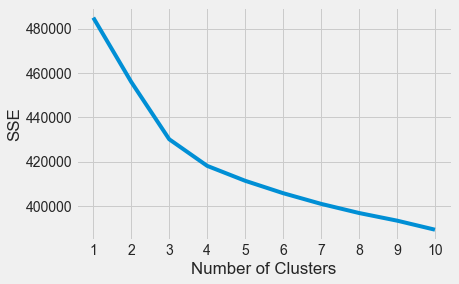

In [15]:
#plotting number of clusters as a function of SSE
plt.style.use('fivethirtyeight')
plt.plot(range(1,11), sse)

plt.xticks(range(1,11))

plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show

In [16]:
#using python package kneed to identify elbow programatically 
kl = KneeLocator(range(1,11), sse, curve='convex', direction='decreasing')
kl.elbow

4

In [17]:
#fitting the custering algorithm on X
kmeans = KMeans(n_clusters=4,
               max_iter=300 #default
               ).fit(X)

In [18]:
# print('centers')
# print(kmeans.cluster_centers_)

# print('labels')
# print(kmeans.labels_)

# for point, label in zip(X, kmeans.labels_):
#     print('coordinates',point, 'label:', label)

### **Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.**

The cluster 2 points tend to be on the higher end of the income to poverty line ratio, whereas the cluster 1 points tend to be on the lower end of the income to poverty line ratio. Cluster 0 and cluster 3 seem to be scattered throughout, but more of the cluster 0 points are on the lower end of the income to poverty line ratio and the cluster 3 points tend to be on the higher end of that ratio.


In [19]:
#creating column cluster in X dataframe and giving it labels
X['cluster'] = kmeans.labels_

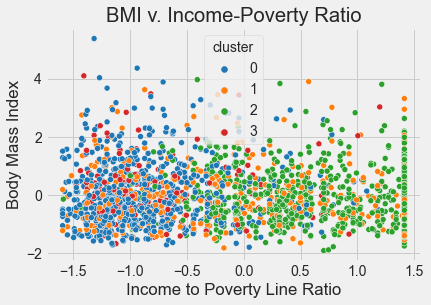

In [20]:
#this is the BMI vs poverty line plot colored by different clusters
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "cluster", palette = "tab10", data = X)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [86]:
#list holds SSE_pca values for each k but for pca data
    # paul: subset pca_df so that kmeans only fit on the first 4 components 
        # (not sure if this really changed anything)
sse_pca = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pca_df.iloc[:, : 4])
    sse_pca.append(kmeans.inertia_)

<function matplotlib.pyplot.show(*args, **kw)>

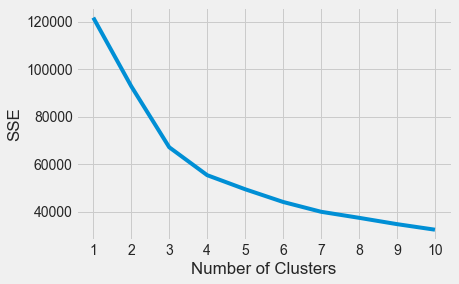

In [87]:
#plotting number of clusters as function of SSE for pca
plt.style.use('fivethirtyeight')
plt.plot(range(1,11), sse_pca)

plt.xticks(range(1,11))

plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show

In [88]:
#using python package kneed to identify elbow programatically 

kl = KneeLocator(
range(1,11), sse_pca, curve='convex', direction='decreasing')

kl.elbow

4

In [90]:
#fitting clusters to pca data
kmeans_pca = KMeans(n_clusters=4,
               max_iter=300 #default
               ).fit(pca_df.iloc[:, : 4])

### Plot the clusters on top of the 2D PCA scatterplot from the previous step.

We are plotting the first principal component on the x axis and the second principal component on the y axis. There are four clusters that seem to be spread out across the graph.  

In [93]:
#adding cluster column to pca data and giving it kmeans labels
    # paul: changed this from kmeans.labels_ to kmeans_pca.labels_
pca_df['cluster'] = kmeans_pca.labels_
kmeans.labels_

array([3, 9, 6, ..., 4, 3, 8], dtype=int32)

<Figure size 432x288 with 0 Axes>

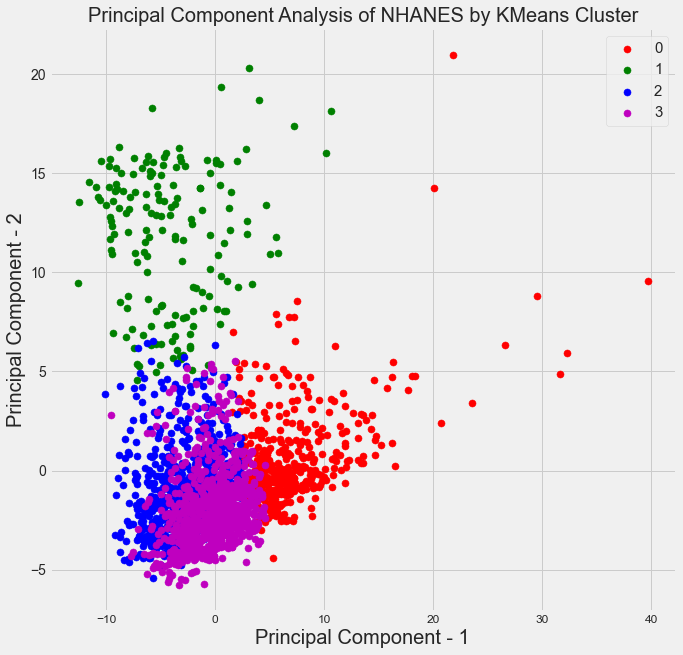

In [101]:
#not sure why this is giving us cluster 0,3,6,9
    # paul: i think I figured it out, see note in cell above

#scatterplot of pca 1 vs pvca 2 colored by cluster 

#sns.scatterplot(x='principal component 1', y= 'principal component 2', hue='cluster', data = pca_df)
#plt.title('PCA 1 vs PCA 2 Using KMeans')


plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES by KMeans Cluster",fontsize=20)
targets = [i for i in set(pca_df['cluster'])]
colors = ['r', 'g', 'b', 'm']

for target, color in zip(targets,colors):
    indicesToKeep = pca_df['cluster'] == target
    plt.scatter(pca_df.loc[indicesToKeep.reset_index(drop = True), 'principal component 1']
               , pca_df.loc[indicesToKeep.reset_index(drop = True), 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

## Neural Network

**Target Variable: Binary** 
Descriptive analysis shows that the binary variable HSD010_binary provides a helpful simplification of the 5-category self rated health variable. We decide to continue our analysis with this variable to improve the accuracy of our predictions.

**Train-Test Split: 1:4** 
Our dataset contains only 2064 observations. We decide to save 25% for testing.

In [62]:
# If using all categories
# y = nhanes_scaled['HSD010'] 
# y = y.replace(['excellent', 'very good', 'good', 'fair', 'poor'],[1, 2, 3, 4, 5])

#If using binary categories
y = nhanes_scaled['HSD010_binary'] 
y = y.replace(['good','poor'],[0,1])

### 1. Neural Network on Original Features

In [75]:
# Re-create X to avoid including process varibales that might have been added during previous stages of the analysis
X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1,inplace=False)
# Split the dataset to training and testing groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

# Since we use the binary variable, we assign 2
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes= y_test.shape[1]

#Create model
model_org_features = Sequential()

model_org_features.add(
    Dense(X_test.shape[1], input_dim=X_test.shape[1], kernel_initializer='normal', activation='relu')
    )

model_org_features.add(
    Dense(num_classes,  kernel_initializer='normal', activation='softmax')
    )

model_org_features.add(Flatten()) # A flatten layer

model_org_features.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_org_features.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=False)

#Evaluate model
scores_org_features = model_org_features.evaluate(X_test, y_test, verbose=2)

17/17 - 0s - loss: 0.7003 - accuracy: 0.8643


### 2. Neural Network on Principal Components

In [79]:
# We Create a new dataset from the first 3 principle componants
X_pca = pca_df.iloc[:, list(range(3))]

#create training datasets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size = .25, random_state = 10)

# Since we use the binary variable, we assign 2
num_classes = 2
y_train_pca = keras.utils.to_categorical(y_train_pca, num_classes)
y_test_pca = keras.utils.to_categorical(y_test_pca, num_classes)
num_classes_pca = y_test_pca.shape[1]

#Create model
model_pca = Sequential()

model_pca.add(
    Dense(X_test_pca.shape[1], input_dim=X_test_pca.shape[1], kernel_initializer='normal', activation='relu')
    )

model_pca.add(
    Dense(num_classes_pca,  kernel_initializer='normal', activation='softmax')
    )
model_org_features.add(Flatten()) # A flatten layer

model_pca.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_pca.fit(X_train_pca, y_train_pca, validation_data=(X_test_pca, y_test_pca), epochs=100, batch_size=200, verbose=False)

#Evaluate model
scores_pca = model_pca.evaluate(X_test_pca, y_test_pca, verbose=2)

17/17 - 0s - loss: 0.3747 - accuracy: 0.8488


### 3. Neural Network on PCA components and the predicted class membership

In [81]:
#We add the clusters to the PCA dataset
X_pca_cluster=X_pca.assign(cluster = kmeans.labels_)

#create training datasets
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_pca_cluster, y, test_size = .33, random_state = 10)

# if using all health categories, then we have 5 classes
num_classes = 2
y_train_cluster = keras.utils.to_categorical(y_train_cluster, num_classes)
y_test_cluster = keras.utils.to_categorical(y_test_cluster, num_classes)
num_classes_cluster = y_test_cluster.shape[1]

#Create model
model_cluster = Sequential()

model_cluster.add(
     Dense(X_test_cluster.shape[1], input_dim=X_test_cluster.shape[1], kernel_initializer='normal', activation='relu')
     )

model_cluster.add(
    Dense(num_classes_cluster,  kernel_initializer='normal', activation='softmax')
    )

model_cluster.add(Flatten()) # A flatten layer

model_cluster.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cluster.fit(X_train_cluster, y_train_cluster, validation_data=(X_test_cluster, y_test_cluster), epochs=100, batch_size=200, verbose=False)

#Evaluate model
scores_cluster = model_cluster.evaluate(X_test_cluster, y_test_cluster, verbose=2)

22/22 - 0s - loss: 0.3737 - accuracy: 0.8563


### Compare models

In [82]:
Compare_dic = {'Model':  ['Original Features', 'PCA', 'Clustering'],
        'Loss': [scores_org_features[0], scores_pca[0],scores_cluster[0]],
        'Accuracy': [scores_org_features[1], scores_pca[1],scores_cluster[1]]
        }

Compare = pd.DataFrame (Compare_dic, columns = ['Model','Loss','Accuracy'])

print (round(Compare,2))

               Model  Loss  Accuracy
0  Original Features  0.70      0.86
1                PCA  0.37      0.85
2         Clustering  0.37      0.86


Overall all the algorithms performed well with high levels of accuracy. Predicting based on the principle componants improved our loss function. Predicting on PCA+clustering results improved both loss and accuracy, though the latter only by a small margin. In general, since PCA works on colums and clustering works on rows, we would expect the the combined model would perform sognificantely better on accuracy. We suspect that this isn't the case becasuse our classes aren't well separated.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

In [35]:
## Your Answer Here